# Le Teil earthquake epicenter location likelihood

<img src="images/logo-epos.png" style="margin:10px; height:80px;"/><img src="images/logo-esa.png" style="margin:10px; height:100px;"/><img src="images/logo-ipgp-upc.png" style="margin:10px; height:80px;"/>

The original version of this notebook was made by Antoine Lucas and Gregory Sainton. The current notebook was edited in 2023 by Leonard Seydoux (seydoux@ipgp.fr) to be used in the course "Earth Data Science" at the [Institut de Physique du Globe de Paris](https://www.ipgp.fr/fr) (IPGP). If you have found a bug or have a suggestion, please feel free to contact me.

On November 11, 2019, a Mw 4.9 earthquake occured in the south of France, near the city of Le Teil. In this notebook, we will use the seismic data recorded by the RESIF network to estimate the epicenter location by a simple Monte Carlo method. This notebook is planned for the second practical session of the course "Earth Data Science" at IPGP. It is based on the example made by Albert Tarantola [_Estimation of an Epicenter: Direct Use of the Probabilistic Method_](https://www.ipgp.fr/~tarantola/exercices/chapter_02/epicenter/Tarantola/CompleteDocument.pdf). We will use seven stations from the [French part of the EPOS network](https://www.epos-france.fr/) and explore some parameters of the problem. We will also use the InSAR data from the Sentinel-1 satellite to constrain the epicenter location. The production of the InSAR displacement map (available in the `data` repository) was made by Antoine Lucas using SNAP.

In [13]:
import cartopy
import matplotlib.pyplot as plt
import numpy as np
import obspy
from obspy.clients.fdsn import Client
from obspy.signal.trigger import classic_sta_lta, trigger_onset

## 1. Introduction

Introducing to the topic of probabilistic methods, Albert Tarantola wrote in his book [Inverse Problem Theory](https://www.ipgp.fr/~tarantola/Files/Professional/Books/InverseProblemTheory.pdf), edited by Siam in 2005 (p.20):

<div style="padding-left: 20px; width: 90%;">

_Experiments suggest physical theory, and physical theory predict the outcome of experiments. The comparision of the predicted outcome and the observed outcome allows us to ameliorate the theory. It in the "physical theory" we include the physical parameters describing the system under study, then inverse problem theory is about the quantitative rules to be used for this comparison between predictions and observations._

</div>

Solving a _forward problem_ means to predict the error-free values of the observable parameters $d$ that would correspond to a given model $m$. It can be formally written as

$$m \mapsto d = \mathcal{G}(m),$$

where $\mathcal{G}$ is the forward operator, which means the mathematical model of the physical system under study. In our problem, the model parameters $m$ are the coordinates of the epicenter that can be written in the form

$$m = (\lambda, \varphi) \in \mathbb{R}^2,$$

and the data parameters $d$ are the arrival times at the $N$ seismic stations that can be written as

$$d = (t_1, \ldots, t_N) \in \mathbb{R}^N$$

Note that the travel times can be noisy due to several reasons (e.g., the noise in the data, the approximations in the model, etc.). The forward operator $\mathcal{G}$ is the travel time model that predicts the travel times $t_i$ for a given epicenter location $m$. 


## 2. Reading and preparing the data

### 2.1 Event information

Of course when inferring an earthquake epicenter, you have a bare idea of the event's location and time. Here we use the exact information provided by the BRGM (Bureau de Recherches Géologiques et Minières) that is available on the [website of EPOS-France](https://www.epos-france.fr/blog/2021/01/19/reponse-rapide-de-la-communaute-resif-au-tremblement-de-terre-mw-4-9-du-11-novembre-2019-au-teil/). We will then fetch the event information from the EPOS-France web service using the `obspy` package.

In [2]:
earthquake = {
    "latitude": 44.517778,
    "longitude": 4.670833,
    "datetime": obspy.UTCDateTime(2019, 11, 11, 10, 52, 47),
}

### 2.2 Fetch available stations

We can now look for available seismic station around the time and place of the estimated earthaquake location. Note that with the seismic network in France, we have a good coverage of the country and may find already about 10 seismic station with a distance of less than 100km from the epicenter. We will use the `obspy` package to fetch the available stations.

In [3]:
# Connect to the RESIF web service (need internet connection)
client = Client("RESIF")

# Look for station near the epicenter
inventory = client.get_stations(
    network="FR",
    channel="*",
    starttime=earthquake["datetime"] - 10,
    endtime=earthquake["datetime"] + 120,
    latitude=earthquake["latitude"],
    longitude=earthquake["longitude"],
    maxradius=1,
    matchtimeseries=True,
)

# Print inventory
print(inventory)

Inventory created at 2023-12-17T09:49:51.000000Z
	Created by: RESIF WEB SERVICE: fdsnws-station | version: 1.1.1 
		    http://ws.resif.fr/fdsnws/station/1/query?starttime=2019-11-...
	Sending institution: RESIF-SI (RESIF-DC)
	Contains:
		Networks (1):
			FR
		Stations (17):
			FR.ADHE (La Garde-Adhémar)
			FR.BALS (Balsièges)
			FR.BANN (fort de Banne)
			FR.MLYF (le Clot de Melly)
			FR.OGCB (Combovin)
			FR.OGCC (col des Casset)
			FR.OGCN (Le Chalon)
			FR.OGDF (Dieulefit)
			FR.OGS1 (Séchilienne)
			FR.OGS2 (Séchilienne)
			FR.OGS3 (Séchilienne)
			FR.REST (domaine de Restinclières)
			FR.RUSF (Rustrel)
			FR.SAUF (Saumane-de-Vaucluse)
			FR.SGSF (Siaugues-Sainte-Marie)
			FR.TRBF (grotte de Trabuc)
			FR.VAL4 (Valence)
		Channels (0):



### 2.3 Show the seismic stations on a map

We can display the location of the stations on a map using the cartopy package. This is always useful to look at the station distribution and get a rough idea of the task ahead.

/Users/seydoux/anaconda3/envs/viens/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/Users/seydoux/anaconda3/envs/viens/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/Users/seydoux/anaconda3/envs/viens/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/Users/seydoux/anaconda3/envs/viens/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_lakes.zip
  warnings.warn(f'Downloading: {url}', Down

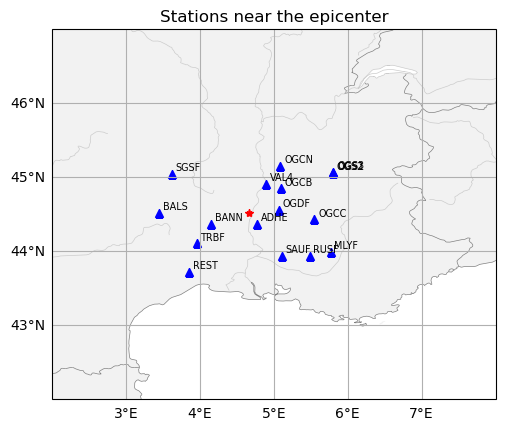

In [4]:
DOMAIN_EXTENT = 2, 8, 42, 47

fig, ax = plt.subplots(subplot_kw={"projection": crs.PlateCarree()})

# Some map settings
ax.add_feature(feature.LAND, facecolor="0.95")
ax.add_feature(feature.BORDERS, linewidth=0.5, edgecolor="0.5")
ax.add_feature(feature.COASTLINE, linewidth=0.5, edgecolor="0.5")
ax.add_feature(feature.LAKES, facecolor="w", linewidth=0.5, edgecolor="0.8")
ax.add_feature(feature.RIVERS, linewidth=0.5, edgecolor="0.8")
ax.set_extent(DOMAIN_EXTENT)

# Plot earthquake location
ax.plot(earthquake["longitude"], earthquake["latitude"], "r*", transform=crs.PlateCarree())

# Plot station locations
for network in inventory:
    for station in network:
        ax.plot(
            station.longitude,
            station.latitude,
            "b^",
            transform=crs.PlateCarree(),
        )
        ax.text(
            station.longitude + 0.05,
            station.latitude + 0.05,
            station.code,
            transform=crs.PlateCarree(),
            fontsize="x-small",
        )

# Add labels
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.set_title("Stations near the epicenter")

# Show
plt.show()

### 2.4 Download the seismic records

We can now download the seismic waveforms from the seismic stations we have found in the previous step. We will use the `obspy` package to fetch the seismic records. We will work at the natural sampling rate of the stations, which is 100Hz for most of them. We will also use the `obspy` package to plot the seismic records.

In [6]:
client = Client("RESIF")

stream = obspy.Stream()

for network in inventory:
    for station in network:
        try:

            # Get waveform data
            trace = client.get_waveforms(
                network.code,
                station.code,
                "*",
                "HHZ",
                earthquake["datetime"] - 10,
                earthquake["datetime"] + 120,
            )

            # Merge data
            trace.merge(fill_value="interpolate")

            # Add station location
            trace[0].stats.coordinates = {
                "latitude": station.latitude,
                "longitude": station.longitude,
            }

            # Add to stream
            stream += trace[0]

        except:
            print("No data for station %s" % station.code)
            continue

# Save stream as pickle file to keep the coordinates (not possible with miniseed)
stream.write("data/waveforms.pickle", format="PICKLE")

No data for station ADHE
No data for station OGS1
No data for station REST
No data for station SGSF
No data for station TRBF
No data for station VAL4


### 2.5 Plot the waveforms and pick the P-wave arrival times

Now we can explore the data and pick the arriver times of the P-wave. We will use the `obspy` package to plot the seismic records and pick the arrival times. 

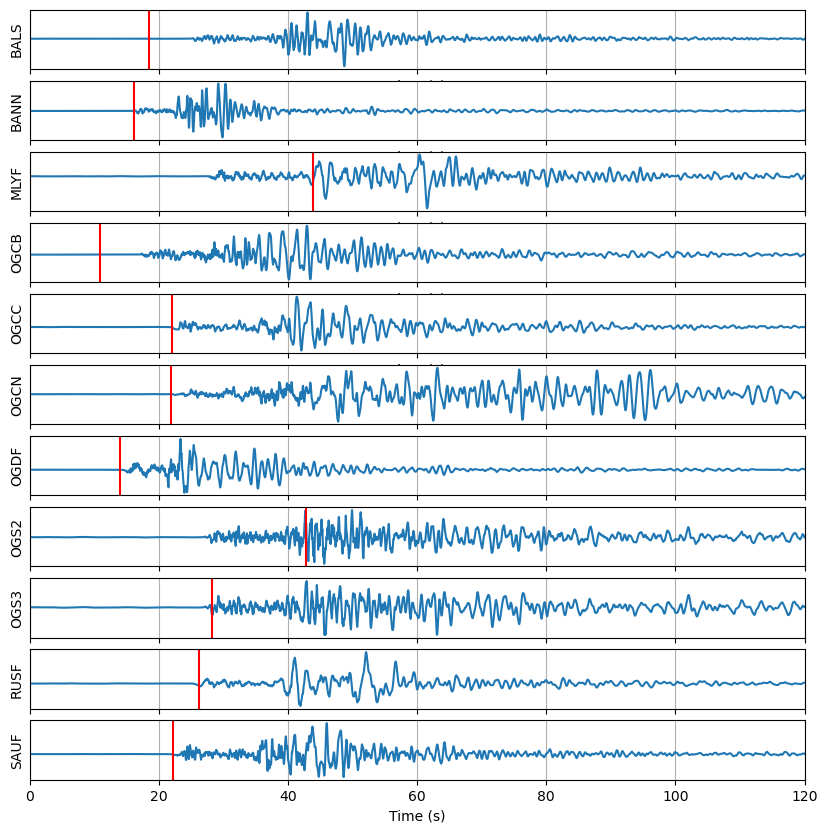

In [7]:
# Read waveforms from pickle file
stream = obspy.read("data/waveforms.pickle")

sta = 1 * stream[0].stats.sampling_rate
lta = 10 * stream[0].stats.sampling_rate

# Get firt arrive time
for trace in stream:
    trigger = classic_sta_lta(trace.data, sta, lta)
    onset = trigger_onset(trigger, 4, 0.5)
    
    if np.size(onset) > 0:
        
        onset = onset[0, 0]
        trace.stats.onset = onset / trace.stats.sampling_rate
    # if np.amin(onset):
    #     onset = onset[0, 0]
    #     trace.stats.onset = onset / trace.stats.sampling_rate
    else:
        print("No onset found for %s" % trace.id)
        stream.remove(trace)

# Plot waveforms
fig, axes = plt.subplots(len(stream), sharex=True, figsize=(10, 10))
for ax, trace in zip(axes, stream):
    ax.plot(trace.times(), trace.data)
    ax.axvline(trace.stats.onset, color="r")
    ax.set_xlim(0, 120)
    ax.set_yticks([])
    ax.set_xlabel("Time (s)")
    ax.set_ylabel(trace.stats.station)
    ax.grid()

## 3. Inverse problem

### 3.1 Theoritical reminds

The coordinates of the seismic stations and the velocity of the _P_ wave are assumed which means that the velocities uncertainties are supposed to be negligible in comparison with the uncertainties of the observed arrival times. For a source located at the position $x = (\lambda, \varphi)$, the arrival times $\hat{t}_i$ of the seismic wave recorded at station $i$ located at $x_i = (\lambda_i, \varphi_i)$ are predicted by the travel time model $\mathcal{G}$ as

$$ \hat{t}_i = \mathcal{G}_i(x_i) = \frac{\mathcal{D}(x, x_i)}{v},$$

where the velocity $v$ is considered to be constant for the sake of simplicity. The function $\mathcal{D}$ is the great circle distance between the source and the station. From the lecture, we know that the _posterior_ information $\sigma(m)$ is a combination of all informations we have which can be expressed as 

$$\sigma(m) = k \rho(m) \mathcal{L}(m)$$

where $k$ is a normalization constant, $\rho(m)$ is the *a priori* and $\mathcal{L}(m)$ is the likelihood function. If we consider the uncertainties to be Gaussian with a standard deviation $\nu$, the likelihood function $L(m)$ is expressed as:

$$ L(m) = k' \exp -\frac{1}{2} \sum\limits_{i=1}^{n} \left(\frac{t_{i}-\hat{t}_i}{\nu}\right)^2 $$

where $k'$ is a normalization constant. Injecting the likelihood function into the posterior information, we obtain:

$$
\sigma(m) = kk' \rho(m) \exp-\frac{1}{2} \sum_{i=1}^{n} \left(\frac{t_{i}-\hat{t}_i}{\nu}\right)^2
$$

For now we can take the a priori information $\rho(m)$ as a constant, since we do not have yet a priori information about the epicenter location. We will come back to this point later. The posterior information $\sigma(m)$ is then proportional to the likelihood function $\mathcal{L}(m)$, which means that the maximum of the posterior information is also the maximum of the likelihood function. We can then maximize the likelihood function to find the epicenter location, denoted $m^*$, that best fits the data. The maximum of the likelihood function is obtained by maximizing the following function:

$$
m^* = \arg\max\limits_{m} \quad \exp-\frac{1}{2} \sum\limits_{i=1}^{n} \left(\frac{t_{i}-\hat{t}_i}{\nu}\right)^2
$$

### 3.2 Working with few stations

At first we will work with (deliberately) too few seismic stations which naturally brings biases in the estimation of the epicenter location. We will select three stations located in a line along the Rhône valley: OGCN, OGCB, and OGDF. 

In [8]:
stream_1 = stream.select(station="OG*")

# Remove OGCC station
stream_1 = stream_1.remove(stream_1.select(station="OGCC")[0])
stream_1 = stream_1.remove(stream_1.select(station="OGS2")[0])
stream_1 = stream_1.remove(stream_1.select(station="OGS3")[0])

Now the idea is to sample the probability density $\mathcal{L}(m)$ at random positions $m$ to have an idea of the entire probability distribution. 

In [9]:
def monte_carle_gaussian(traces, sigma=20, v=3, shots=100, extent=DOMAIN_EXTENT):
    
    # Shoot random points in the domain
    longitudes = np.random.uniform(extent[0], extent[1], shots)
    latitudes = np.random.uniform(extent[2], extent[3], shots)

    # Compute the travel time for each point
    t_hat = []
    for trace in traces:
        lat = trace.stats.coordinates["latitude"]
        lon = trace.stats.coordinates["longitude"]
        distance = obspy.geodetics.base.locations2degrees(
            lat, lon, latitudes, longitudes
        )
        t_hat.append(distance * 111.19 / v)

    # Turn into a numpy array
    t_hat = np.array(t_hat)

    # Get observed travel times
    t_obs = np.array([trace.stats.onset for trace in traces])

    # Compute the likelihood
    likelihood = np.exp(-0.5 * np.sum((t_hat - t_obs[:, None]) ** 2 / sigma ** 2, axis=0))
    likelihood /= np.max(likelihood)
    
    return latitudes, longitudes, likelihood

### 3.3 Plot the likelihood

Compute here the likelihood function $\mathcal{L}(m)$ for a grid of epicenter locations $m$ and plot it. You can use the `matplotlib` package to plot the likelihood function.

In [10]:
latitudes, longitudes, likelihood = monte_carle_gaussian(
    stream_1, shots=40000, sigma=10, v=3
)

/Users/seydoux/anaconda3/envs/viens/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


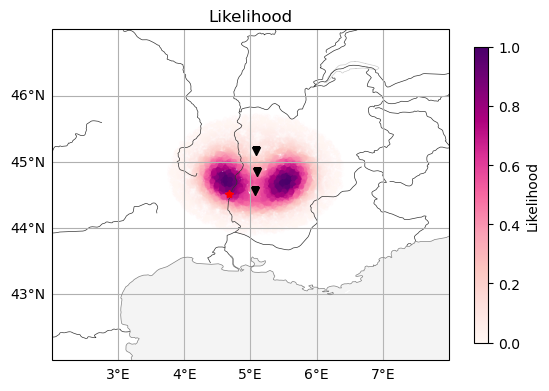

In [11]:

# Plot the likelihood
fig, ax = plt.subplots(subplot_kw={"projection": crs.PlateCarree()})
ax.add_feature(feature.OCEAN, facecolor="0.8", alpha=0.2, zorder=10)
ax.add_feature(feature.BORDERS, linewidth=0.5, edgecolor="0.2")
ax.add_feature(feature.COASTLINE, linewidth=0.5, edgecolor="0.5", zorder=10)
ax.add_feature(feature.LAKES, facecolor="w", linewidth=0.5, edgecolor="0.8")
ax.add_feature(feature.RIVERS, linewidth=0.5, edgecolor="0.2")
ax.set_extent(DOMAIN_EXTENT)

# Plot station locations
for trace in stream_1:
    ax.plot(
        trace.stats.coordinates["longitude"],
        trace.stats.coordinates["latitude"],
        "vk",
        transform=crs.PlateCarree(),
    )

# Plot earthquake location
ax.plot(
    earthquake["longitude"],
    earthquake["latitude"],
    "r*",
    transform=crs.PlateCarree(),
)
img = ax.scatter(
    longitudes,
    latitudes,
    c=likelihood,
    transform=crs.PlateCarree(),
    zorder=0,
    cmap="RdPu",
    s=10,
    alpha=likelihood
)
plt.colorbar(img, ax=ax, label="Likelihood", shrink=0.8)

# Add labels
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.set_title("Likelihood")

# Show
plt.show()

### 3.3. Working with all the stations

Now we will work with all the stations we have found in the previous step.

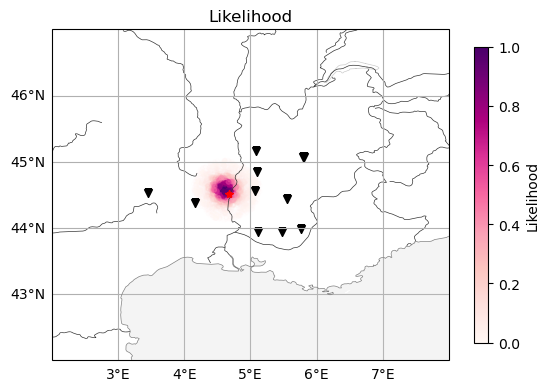

In [12]:
latitudes, longitudes, likelihood = monte_carle_gaussian(
    stream, shots=40000, sigma=10, v=3
)

# Plot the likelihood
fig, ax = plt.subplots(subplot_kw={"projection": crs.PlateCarree()})
ax.add_feature(feature.OCEAN, facecolor="0.8", alpha=0.2, zorder=10)
ax.add_feature(feature.BORDERS, linewidth=0.5, edgecolor="0.2")
ax.add_feature(feature.COASTLINE, linewidth=0.5, edgecolor="0.5", zorder=10)
ax.add_feature(feature.LAKES, facecolor="w", linewidth=0.5, edgecolor="0.8")
ax.add_feature(feature.RIVERS, linewidth=0.5, edgecolor="0.2")
ax.set_extent(DOMAIN_EXTENT)

# Plot station locations
for trace in stream:
    ax.plot(
        trace.stats.coordinates["longitude"],
        trace.stats.coordinates["latitude"],
        "vk",
        transform=crs.PlateCarree(),
    )

# Plot earthquake location
ax.plot(
    earthquake["longitude"],
    earthquake["latitude"],
    "r*",
    transform=crs.PlateCarree(),
)
img = ax.scatter(
    longitudes,
    latitudes,
    c=likelihood,
    transform=crs.PlateCarree(),
    zorder=0,
    cmap="RdPu",
    s=10,
    alpha=likelihood
)
plt.colorbar(img, ax=ax, label="Likelihood", shrink=0.8)

# Add labels
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.set_title("Likelihood")

# Show
plt.show()

As we can see on these plots, the time picking for OGCC is erroneous. Actually, this means that the problem is statistically biaised. In fact, we introduced an aberrant arriving time ```Tobs```  at  one station.  Because the Gaussian assumption is used, the result is very sensitive to big errors (even if there is a small number of them).

### 3.4. Deal with biases in dataset

 Your are invited to consider changing the Gaussian model by the more robust Laplacian model,
and/or introducing a priori information.  

First, here is the Laplace distribution:

$\begin{equation}
L_L(m) = k.exp{\left[-\sum\limits_{i=1}^{n} \frac{\lvert t_{i}-t_{obs}\lvert}{\sigma_i}\right]} \tag{6}
\end{equation}$

where $k$ is a normalization constant. For sake of simplicity of this lab, we can ignore it. 

#### Questions

1. Modify the function ```MC_Gauss(...)``` to ```MC_Laplace(...)``` to use the Laplacian distribution.
2. Make your function run over the parameters space and plot the results
3. Which station is concerned by the biais?



##### Solutions

<AxesSubplot:title={'center':'EQ estimation from 7 stations, with an error on 1 station (Laplacian dist.)'}, xlabel='Easting (km)', ylabel='Northing (km)'>

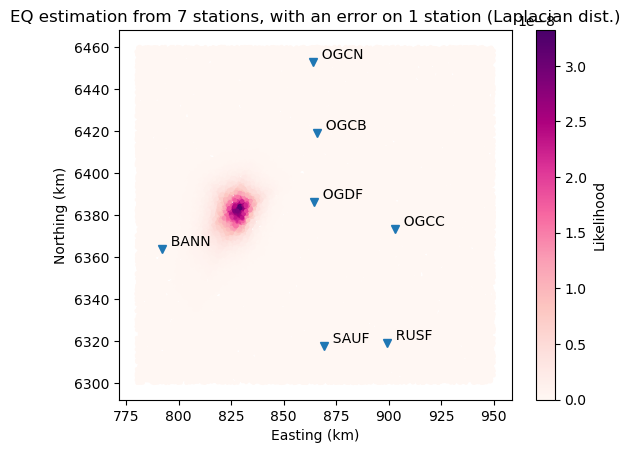

In [54]:
def monte_carlo_laplace(problem1, param_space):
    
    Tstep = problem1["Tobs"].to_numpy()
    Sstep = problem1["sigma"].to_numpy()
    Xstep = problem1["longitude"].to_numpy()
    Ystep = problem1["latitude"].to_numpy()

    gobs=[]

    for idx in range(0, int(param_space["n_run"])):

        Xeq = random.uniform(param_space["Xmin"], param_space["Xmax"])
        Yeq = random.uniform(param_space["Ymin"], param_space["Ymax"])
        
        Tcal = np.sqrt((Xeq - Xstep)**2 + (Yeq - Ystep)**2)/param_space["v"]

        LFG = np.divide(np.abs(Tcal - Tstep), Sstep)
        LFG = np.exp(-1/2.*np.sum(LFG))

        gobs.append([Xeq, Yeq, LFG]);

    gobs  = np.array(gobs)


    return gobs


# RUN THE CODE
gobs_laplace = MC_Laplace(problem2, param_space)

title='EQ estimation from 7 stations, with an error on 1 station (Laplacian dist.)'
plot_dist_obs(gobs_laplace, problem2, title)

#### Comments
Accounting for a more robust model, the inversion is somewhat less biaised and the result is better. 

### 3.5. Introducing a priori information from InSAR

Now, we will add a priori information from surface displacement obtained from Sentinel-S1 InSAR between the Nov. 6 and Nov. 12. First, we need to read the displacement map. The results are contained in a GeoTiff file ``InSAR_S1/Drome_EQTeil_displacement_VV_06Nov2019_12Nov2019.tif``. This file comes with Geo Tags in Exifs. For reading these metadata various libs exist, such as ``rasterio``, ``georaster``, ``osgeo``. ``PIL`` and ``OpenCV`` are other image processing libraries that could be also considered. Because you may not have these libs installed, we made a copy into a PNG flat file that can be directly read with ``matplotlib`` or ``scipy`` that should be present in your system. Unfortunately, the Geo tags are no more present into the file and the image footprint in Lamber 93 system needs to be manually provided as:

```python
ul=[825930.7,6376723.7]
lr=[840754.7,6387758.4]
```

Note that we do a simplistic remapping of the geographic coordinates which is sufficient for the purpose of the lab but a proper warping should be done for accurate results. For those interested in exploring the geospatial approach   the mandatory libs need to be installed. You would need the ``Scripts/ConvertProj.ipynb`` for converting the geographic coordinates into Lambert-93.

In [56]:
ul=[825930.7,6376723.7]
lr=[840754.7,6387758.4]

**Hint**

The ``.imread`` function of ``matplotlib`` returns a ``numpy.array``

In [55]:
im = plt.imread('data/Drome_EQTeil_displacement_VV_06Nov2019_12Nov2019.png')

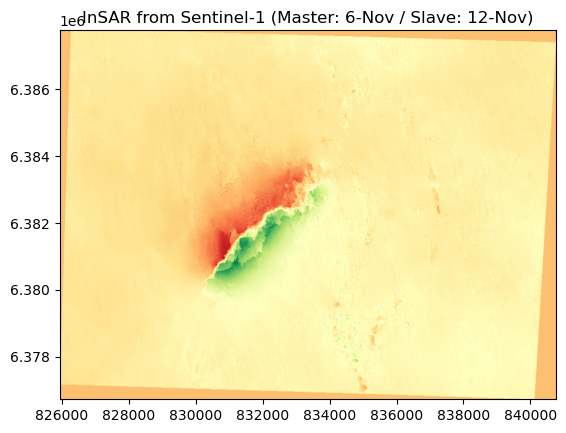

In [58]:
fig, ax = plt.subplots()
ax.imshow(im,interpolation='bilinear', cmap=cm.RdYlGn,
               extent=[ul[0], lr[0],ul[1], lr[1]])
plt.title('InSAR from Sentinel-1 (Master: 6-Nov / Slave: 12-Nov)')
ax.set_aspect('equal', 'box')

Let's use this location as a prior on the inversion. We take the center of the displaced area in X coordinate (named ``xx``) and we take an uncertainties sigma of  the lateral extend (i.e., ``sigma2``). Then we compute a prior with a Gaussian distribution, centered in ``xx`` with a standard deviation ``sigma2``. We test with ```MC_Gauss(...)``` function and the ``problem2`` defined above : 
```python
xx=832000;
sigma2=2000;
```

<AxesSubplot:title={'center':'EQ estimation from 3 stations, with Prior'}, xlabel='Easting (km)', ylabel='Northing (km)'>

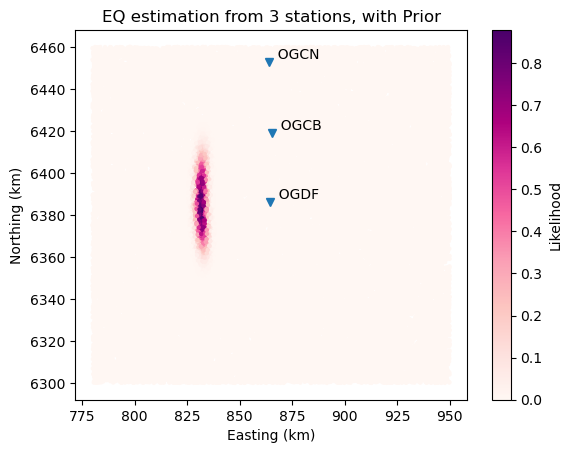

In [59]:
xx=832000; 
sigma2=2000;
#yy=6382000

gobs_InSar = MC_Gauss(problem1, param_space)


fprior =    np.exp( -0.5* (gobs_InSar[:,0] - xx)**2/sigma2**2)

gobs_InSar[:,2] = fprior*gobs_InSar[:,2];
title = 'EQ estimation from 3 stations, with Prior'
plot_dist_obs(gobs_InSar, problem1, title)

#### Comments

Providing an a priori when the observable are biased (i.e., problem1) is strongly helpfull.

Now, let's play with problem2:

<AxesSubplot:title={'center':'EQ estimation from 7 stations, with Prior and error'}, xlabel='Easting (km)', ylabel='Northing (km)'>

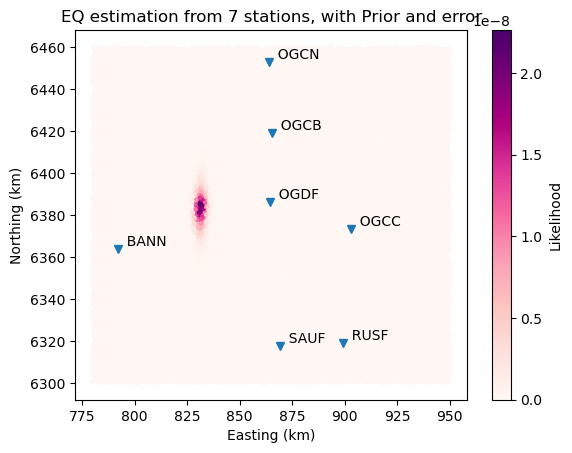

In [60]:
gobs_InSar2 = MC_Laplace(problem2, param_space)
fprior =    np.exp( -0.5* (gobs_InSar2[:,0] - xx)**2/sigma2**2)
gobs_InSar2[:,2] = fprior*gobs_InSar2[:,2];
title = 'EQ estimation from 7 stations, with Prior and error'
plot_dist_obs(gobs_InSar2, problem2, title)

The solution is helped by the a priori knowledge of the problem. 

### 3.6 Further investigations 
First, let evaluate our solution with the actual one.

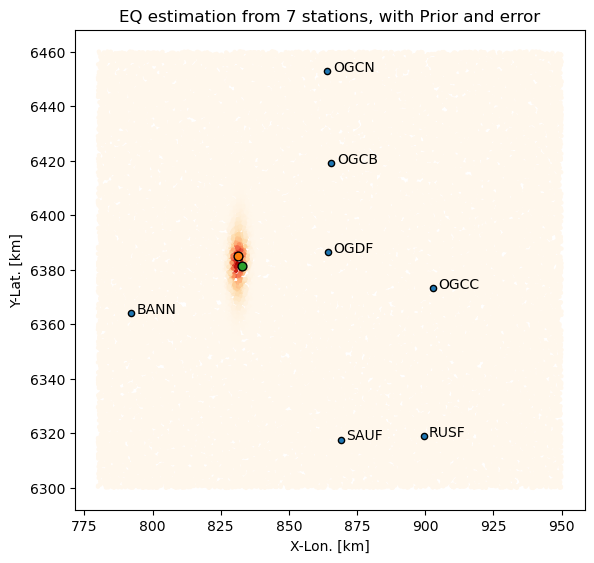

In [61]:
# Here we search for the maximum probability, but keep in mind that the less probable solution are still valid.

ind = np.where(gobs_InSar2[:,2]==np.max(gobs_InSar2[:,2]))
Xprob = gobs_InSar2[ind,0] ; Yprob = gobs_InSar2[ind,1]

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(gobs_InSar2[:,0]/1000., gobs_InSar2[:,1]/1000., edgecolors='none', 
               s=10, c=gobs_InSar2[:,2], cmap=plt.cm.OrRd)          
ax.scatter(problem2["longitude"]/1000., problem2["latitude"]/1000.,
               edgecolors='k',s=20)
ax.scatter(Xprob/1000,Yprob/1000,edgecolors='k',s=40)

# Actual location from references:
XEQ=832796
YEQ=6381286
ax.scatter(XEQ/1000,YEQ/1000, edgecolors='k',s=40)

ax.set(xlabel='X-Lon. [km]', ylabel='Y-Lat. [km]', 
           title=title)
ax.set_aspect('equal', 'box')
for i, point in problem2.iterrows():
        ax.text(point['longitude']/1000.+2, point['latitude']/1000., str(point['station']))
         
plt.show()

We see that our most probable solution is closed to the actual's. In any case, the actual solution is inside our most probable area. So even with our simplifications and biais for one station, our solution is acceptable.

Now, let's retrieve the correct time arrival at ``OGCC`` from our most probable location.

In [62]:
Xstep=problem2[problem2["station"].isin(["OGCC"])]["longitude"].to_numpy()
Ystep=problem2[problem2["station"].isin(["OGCC"])]["latitude"].to_numpy()
Tcal = np.sqrt((Xprob - Xstep)**2 + (Yprob - Ystep)**2)/param_space["v"]
problem_corr = problem2.copy()
problem_corr.head()

,station,latitude,longitude,elevation,filename,Tobs,sigma
0,BANN,6363993.0,792139,447.0,Unknown,7.0,2.0
1,OGCB,6418973.0,865628,738.0,Unknown,8.7,4.0
2,OGCC,6373282.0,902942,1250.0,Unknown,53.4,1.2
3,OGCN,6452684.7,864138,300.0,Unknown,14.2,3.0
4,OGDF,6386363.0,864306,709.0,Unknown,6.6,1.0


In [21]:
problem_corr.loc[problem_corr["station"].isin(["OGCC"]), 'Tobs'] = Tcal
data_picking.loc[data_picking["station"].isin(["OGCC"]), 'Tobs'] = Tcal

problem_corr.head()

,station,latitude,longitude,elevation,filename,Tobs,sigma
0,BANN,6363993.0,792139,447.0,./data/csv/FR_BANN_00_100.0_2019-11-11T10_50_1...,7.000000,2.0
1,OGCB,6418973.0,865628,738.0,./data/csv/FR_OGCB_00_100.0_2019-11-11T10_50_1...,8.700000,4.0
2,OGCC,6373282.0,902942,1250.0,./data/csv/FR_OGCC_00_100.0_2019-11-11T10_50_1...,13.559479,1.2
3,OGCN,6452684.7,864138,300.0,./data/csv/FR_OGCN_00_100.0_2019-11-11T10_50_1...,14.200000,3.0
4,OGDF,6386363.0,864306,709.0,./data/csv/FR_OGDF_00_100.0_2019-11-11T10_50_1...,6.600000,1.0


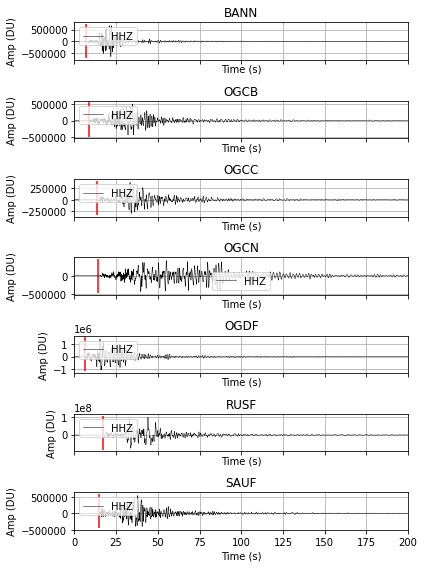

In [22]:
plot_trace(problem_corr)

Let's play with some parameter of the model, for example, let's try v = 5041;

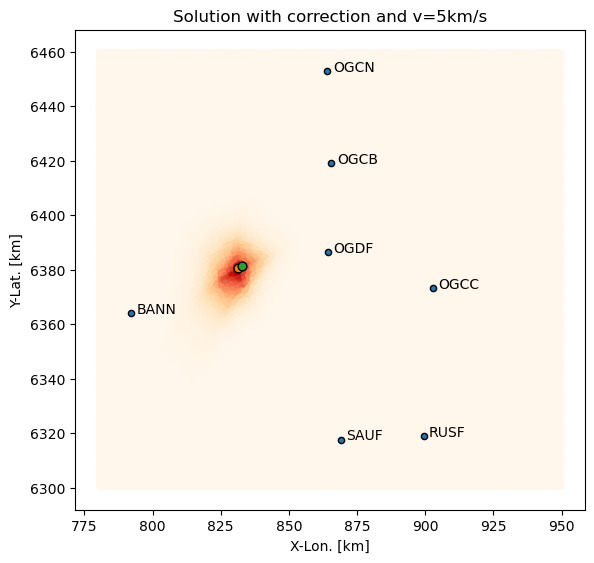

In [63]:
param_space = {}

param_space["Xmin"] = 7.8e5 
param_space["Xmax"] = 9.5e5;
param_space["Ymin"] = 6.3e6; 
param_space["Ymax"] = 6.46e6;
param_space["n_run"]= 5e5;  
param_space["v"]    = 5041; 

sol_corr = MC_Laplace(problem_corr, param_space)

ind = np.where(sol_corr[:,2]==np.max(sol_corr[:,2]))
Xprob = sol_corr[ind,0] ; Yprob = sol_corr[ind,1]


title='Solution with correction and v=5km/s'
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(sol_corr[:,0]/1000., sol_corr[:,1]/1000., edgecolors='none', 
               s=10, c=sol_corr[:,2], cmap=plt.cm.OrRd)          
ax.scatter(problem_corr["longitude"]/1000., problem_corr["latitude"]/1000.,
               edgecolors='k',s=20)
ax.scatter(Xprob/1000,Yprob/1000,edgecolors='k',s=40)

# Actual location from references:
XEQ=832796
YEQ=6381286
ax.scatter(XEQ/1000,YEQ/1000, edgecolors='k',s=40)

ax.set(xlabel='X-Lon. [km]', ylabel='Y-Lat. [km]', 
           title=title)
ax.set_aspect('equal', 'box')
for i, point in problem_corr.iterrows():
        ax.text(point['longitude']/1000.+2, point['latitude']/1000., str(point['station']))
         
plt.show()

Our solution becomes really close the real one.

## Some references

CNRS report (in French):
https://www.cnrs.fr/fr/seisme-du-teil-vers-une-reevaluation-du-risque-sismique-en-france-et-en-europe-de-louest

Journal article (in English): https://doi.org/10.1038/s43247-020-0012-z